In [ ]:
!pip install langchain-tavily transformers datasets

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
data_path = '/content/drive/MyDrive/DLS_PROJECT/AGENT/data/data_final_for_dls_new.jsonl'
eval_path = '/content/drive/MyDrive/DLS_PROJECT/AGENT/data/data_final_for_dls_eval_new.jsonl'

data = pd.read_json(path_or_buf=data_path, lines=True)
test_data = pd.read_json(path_or_buf=eval_path, lines=True)

In [ ]:
data['relevance_new'].value_counts()

,count
relevance_new,
1.0,15950
0.0,14441
0.1,4703


In [ ]:
data['relevance_new'] = data['relevance_new'].map({0.0: 0, 0.1: 1, 1.0: 1}).astype(int)

train_data, val_data = train_test_split(data, test_size=0.15, random_state=42)
test_data['relevance_new'] = test_data['relevance_new'].map({0.0: 0, 0.1: 1, 1.0: 1}).astype(int)

In [ ]:
data['relevance_new'].value_counts()

,count
relevance_new,
1,20653
0,14441


In [ ]:
import os
import time
from google.colab import userdata
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_KEY')
tavily = TavilySearch(max_results=15)
tavily

TavilySearch(max_results=15, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

In [ ]:
df = val_data.sample(300, random_state=342)
df['relevance_new'].value_counts(normalize=True)

,proportion
relevance_new,
1,0.546667
0,0.453333


In [ ]:
df.columns

Index(['Text', 'address', 'name', 'normalized_main_rubric_name_ru',
       'permalink', 'prices_summarized', 'relevance', 'reviews_summarized',
       'relevance_new'],
      dtype='object')

In [ ]:
rows = []
for q in tqdm(df['Text'], desc=f'Creating a dataframe:'):
  res = tavily.invoke({'query': q})
  results = res['results']
  for rank, doc in enumerate(results):
    parts = []
    if doc.get('title'):
      parts.append(doc['title'])
    if doc.get('content'):
      parts.append(doc['content'])
    web_text = '\n\n'.join(parts)
    rows.append({
        'query': q,
        'text': web_text,
        'rank': rank,
        })
  time.sleep(0.5)
web_data = pd.DataFrame(rows)
web_data.to_csv(f'/content/drive/MyDrive/DLS_PROJECT/AGENT/data/web_data.csv', index=False)


Creating a dataframe::   0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
web_data = pd.read_csv('/content/drive/MyDrive/DLS_PROJECT/AGENT/data/web_data.csv')
web_data.head()

,query,text,rank
0,адвокаты москвы дмитрий,Адвокат Дмитрий Петров. Услуги адвоката в Моск...,0
1,адвокаты москвы дмитрий,"Ф. Дмитрий – адвокат, юрист – Москва - Zoon.ru...",1
2,адвокаты москвы дмитрий,Адвокат Дмитрий Питиримов | Moscow - Facebook\...,2
3,адвокаты москвы дмитрий,Адвокат Савчишкин Дмитрий Борисович - Адвокаты...,3
4,адвокаты москвы дмитрий,Джулай Дмитрий Иванович - Адвокат в Москве - 2...,4


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
def prompt_1(query, doc):
    return f"""Ты — эксперт по оценке релевантности веб-документов.

Запрос пользователя:
{query}

Веб-документ:
{doc}

КРИТЕРИЙ ОЦЕНКИ:
Если документ прямо отвечает на запрос пользователя или содержит информацию,
которую пользователь искал, ответь «релевантно».
Если документ не отвечает на запрос, не относится к нему или содержит
другую информацию, ответь «нерелевантно».

ЗАПРЕЩЕНО ОТВЕЧАТЬ ЧЕМ-ЛИБО КРОМЕ УКАЗАННЫХ СЛОВ.

ОТВЕТЬ СТРОГО ОДНИМ СЛОВОМ ИЗ СПИСКА:
релевантно
нерелевантно

Ответ:
"""

def prompt_2(query, doc):
    return f"""Ты — строгий классификатор релевантности веб-документов.

Запрос пользователя:
{query}

Веб-документ:
{doc}

КРИТЕРИЙ ОЦЕНКИ:
Если документ прямо отвечает на запрос пользователя или содержит информацию,
которую пользователь искал, ответь «релевантно».
Если документ не отвечает на запрос, не относится к нему или содержит
другую информацию, ответь «нерелевантно».

Ты ОБЯЗАН выбрать только одно слово.
ЗАПРЕЩЕНО ОТВЕЧАТЬ «не знаю», «частично», «зависит» ИЛИ ЛЮБЫМИ ДРУГИМИ СЛОВАМИ.

ОТВЕТЬ СТРОГО ОДНИМ СЛОВОМ ИЗ СПИСКА:
релевантно
нерелевантно

Ответ:
"""

In [ ]:
web_data['prompt_1'] = web_data.apply(lambda x: prompt_1(x['query'], x['text']), axis=1)
web_data.head()

,query,text,rank,prompt_1
0,адвокаты москвы дмитрий,Адвокат Дмитрий Петров. Услуги адвоката в Моск...,0,Ты — эксперт по оценке релевантности веб-докум...
1,адвокаты москвы дмитрий,"Ф. Дмитрий – адвокат, юрист – Москва - Zoon.ru...",1,Ты — эксперт по оценке релевантности веб-докум...
2,адвокаты москвы дмитрий,Адвокат Дмитрий Питиримов | Moscow - Facebook\...,2,Ты — эксперт по оценке релевантности веб-докум...
3,адвокаты москвы дмитрий,Адвокат Савчишкин Дмитрий Борисович - Адвокаты...,3,Ты — эксперт по оценке релевантности веб-докум...
4,адвокаты москвы дмитрий,Джулай Дмитрий Иванович - Адвокат в Москве - 2...,4,Ты — эксперт по оценке релевантности веб-докум...


In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(web_data)
dataset

Dataset({
    features: ['query', 'text', 'rank', 'prompt_1'],
    num_rows: 4253
})

In [ ]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# Функция токенизации
def tokenize_function(example, name):
  return tokenizer(
      example[name][:3000],
      truncation=True,
      max_length=4096,
      )

def make_dataloader(dataset, field_name, batch_size=2):
    tokenized = dataset.map(lambda x: tokenize_function(x, name=field_name), batched=True)
    tokenized = tokenized.remove_columns(
        [c for c in tokenized.column_names if c not in ["input_ids", "attention_mask"]]
    )
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    return DataLoader(tokenized, batch_size=batch_size, collate_fn=data_collator, shuffle=False)


In [ ]:
dataloader_1 = make_dataloader(dataset, 'prompt_1', batch_size=2)

Map:   0%|          | 0/4253 [00:00<?, ? examples/s]

In [ ]:
model.eval()
def predict_relevance(dataloader):
  preds = []

  with torch.no_grad():
    for batch in tqdm(dataloader, desc='Predict relevance:'):
      batch = {k: v.to(model.device) for k, v in batch.items()}

      generated = model.generate(
          **batch,
          max_new_tokens=5,
          do_sample=False, # детерминированно
          temperature=0,
          pad_token_id=tokenizer.eos_token_id
          )
      decoded = tokenizer.batch_decode(generated, skip_special_tokens=True)
      preds.extend(decoded)
  return preds

def parse_relevance(text: str) -> str:
    text = text.lower()
    if "ответ:" in text:
        text = text.split("ответ:")[-1].strip()
    text = text.replace(".", "").replace("\n", "").strip()
    if "нерелев" in text:
        return "нерелевантно"
    if "релев" in text:
        return "релевантно"
    return "unknown"


def postprocess_predictions(raw_preds):
    labels = []
    for text in raw_preds:
        label = parse_relevance(text)
        labels.append(label)
    return labels

In [ ]:
raw_preds_1 = predict_relevance(dataloader_1)
labels_stage_1 = postprocess_predictions(raw_preds_1)
web_data["label_stage_1"] = labels_stage_1
web_data.to_csv('/content/drive/MyDrive/DLS_PROJECT/AGENT/data/data_preds_1.csv')

Predict relevance::   0%|          | 0/2127 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
res = pd.read_csv('/content/drive/MyDrive/DLS_PROJECT/AGENT/data/data_preds_1.csv')
res['label_stage_1'].value_counts()

,count
label_stage_1,
unknown,2606
нерелевантно,1647


In [ ]:
mask = res["label_stage_1"] == "unknown"
res['prompt_2'] = res.apply(lambda x: prompt_2(x['query'], x['text']), axis=1)
dataset_unknown = Dataset.from_pandas(res[mask])
dataloader_2 = make_dataloader(dataset_unknown, "prompt_2")

raw_preds_2 = predict_relevance(dataloader_2)
labels_stage_2 = postprocess_predictions(raw_preds_2)

res.loc[mask, "label_stage_2"] = labels_stage_2
res.to_csv("/content/drive/MyDrive/DLS_PROJECT/AGENT/data/data_preds_2.csv")

Map:   0%|          | 0/2606 [00:00<?, ? examples/s]

Predict relevance::   0%|          | 0/1303 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
res = pd.read_csv("/content/drive/MyDrive/DLS_PROJECT/AGENT/data/data_preds_2.csv")
res = res.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'rank', 'prompt_1', 'prompt_2'])
res.head()


,query,text,label_stage_1,label_stage_2
0,адвокаты москвы дмитрий,Адвокат Дмитрий Петров. Услуги адвоката в Моск...,нерелевантно,NaN
1,адвокаты москвы дмитрий,"Ф. Дмитрий – адвокат, юрист – Москва - Zoon.ru...",unknown,unknown
2,адвокаты москвы дмитрий,Адвокат Дмитрий Питиримов | Moscow - Facebook\...,unknown,нерелевантно
3,адвокаты москвы дмитрий,Адвокат Савчишкин Дмитрий Борисович - Адвокаты...,нерелевантно,NaN
4,адвокаты москвы дмитрий,Джулай Дмитрий Иванович - Адвокат в Москве - 2...,нерелевантно,NaN


In [ ]:
res['label_stage_1'].value_counts()

,count
label_stage_1,
unknown,2606
нерелевантно,1647


In [ ]:
res['label_stage_2'].value_counts()

,count
label_stage_2,
nan,1647
unknown,1464
нерелевантно,1142


In [ ]:
def mark_final(row):
  if row['label_stage_1'] == 'нерелевантно':
    return 'нерелевантно'
  elif row["label_stage_2"] == 'нерелевантно':
    return 'нерелевантно'
  return ''
res["final_label"] = res.apply(mark_final, axis=1)

In [ ]:
res.head()

,query,text,label_stage_1,label_stage_2,final_label
0,адвокаты москвы дмитрий,Адвокат Дмитрий Петров. Услуги адвоката в Моск...,нерелевантно,NaN,нерелевантно
1,адвокаты москвы дмитрий,"Ф. Дмитрий – адвокат, юрист – Москва - Zoon.ru...",unknown,unknown,
2,адвокаты москвы дмитрий,Адвокат Дмитрий Питиримов | Moscow - Facebook\...,unknown,нерелевантно,нерелевантно
3,адвокаты москвы дмитрий,Адвокат Савчишкин Дмитрий Борисович - Адвокаты...,нерелевантно,NaN,нерелевантно
4,адвокаты москвы дмитрий,Джулай Дмитрий Иванович - Адвокат в Москве - 2...,нерелевантно,NaN,нерелевантно


In [ ]:
res.final_label.value_counts()

,count
final_label,
нерелевантно,2789
,1464


In [ ]:
res.to_csv('/content/drive/MyDrive/DLS_PROJECT/AGENT/data/proc_.csv', index=False)

**Дальше размечал сам**

In [ ]:
final_data = pd.read_csv(f'/content/drive/MyDrive/DLS_PROJECT/AGENT/data/final_data.csv')
final_data = final_data.drop(columns=['label_stage_1', 'label_stage_2'])
final_data.head()

,query,text,final_label
0,адвокаты москвы дмитрий,Адвокат Дмитрий Петров. Услуги адвоката в Моск...,релевантно
1,адвокаты москвы дмитрий,"Ф. Дмитрий – адвокат, юрист – Москва - Zoon.ru...",релевантно
2,адвокаты москвы дмитрий,Адвокат Дмитрий Питиримов | Moscow - Facebook\...,релевантно
3,адвокаты москвы дмитрий,Адвокат Савчишкин Дмитрий Борисович - Адвокаты...,релевантно
4,адвокаты москвы дмитрий,Джулай Дмитрий Иванович - Адвокат в Москве - 2...,релевантно


In [ ]:
final_data['final_label'] = final_data['final_label'].replace({'нерелевантно': 0,'релевантно': 1}).astype(int)
final_data.head()

/tmp/ipython-input-3386931655.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_data['final_label'] = final_data['final_label'].replace({'нерелевантно': 0,'релевантно': 1}).astype(int)


,query,text,final_label
0,адвокаты москвы дмитрий,Адвокат Дмитрий Петров. Услуги адвоката в Моск...,1
1,адвокаты москвы дмитрий,"Ф. Дмитрий – адвокат, юрист – Москва - Zoon.ru...",1
2,адвокаты москвы дмитрий,Адвокат Дмитрий Питиримов | Moscow - Facebook\...,1
3,адвокаты москвы дмитрий,Адвокат Савчишкин Дмитрий Борисович - Адвокаты...,1
4,адвокаты москвы дмитрий,Джулай Дмитрий Иванович - Адвокат в Москве - 2...,1


In [ ]:
final_data.final_label.value_counts()

,count
final_label,
0,515
1,486


In [ ]:
# создадим датафрейм для подачи в модель
data = pd.DataFrame({
    'Text': final_data.apply(lambda x: '\n\n'.join([x['query'], x['text']]), axis=1),
    'label': final_data['final_label']
    })
data.head()

,Text,label
0,адвокаты москвы дмитрий\n\nАдвокат Дмитрий Пет...,1
1,адвокаты москвы дмитрий\n\nФ. Дмитрий – адвока...,1
2,адвокаты москвы дмитрий\n\nАдвокат Дмитрий Пит...,1
3,адвокаты москвы дмитрий\n\nАдвокат Савчишкин Д...,1
4,адвокаты москвы дмитрий\n\nДжулай Дмитрий Иван...,1


In [ ]:
data.label.value_counts()

,count
label,
0,515
1,486


In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=0.2, stratify=data['label'], shuffle=True, random_state=42)

In [ ]:
train.label.value_counts()

,count
label,
0,412
1,388


In [ ]:
val.label.value_counts()

,count
label,
0,103
1,98


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

class CatBoostPipeline(BaseEstimator, ClassifierMixin):
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model

    def __repr__(self):
        return f"CatBoostPipeline(vectorizer={self.vectorizer}, model={self.model})"

    def fit(self, X=None, y=None):
        # ничего не обучаем — модель уже обучена
        return self

    def _transform(self, X):
        return self.vectorizer.transform(X.fillna(''))

    def predict(self, X):
        X_vec = self._transform(X)
        return self.model.predict(X_vec)

    def predict_proba(self, X):
        X_vec = self._transform(X)
        return self.model.predict_proba(X_vec)

cb_path = '/content/drive/MyDrive/DLS_PROJECT/AGENT/catboost_pipeline.pkl'
cb = joblib.load(cb_path)
cb

CatBoostPipeline(vectorizer=TfidfVectorizer(max_df=0.85, max_features=65000, min_df=3, ngram_range=(1, 2),
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\b\\w\\w+\\b'), model=<catboost.core.CatBoostClassifier object at 0x7ba07987ed50>)

In [ ]:
cb.model.classes_

array([0, 1])

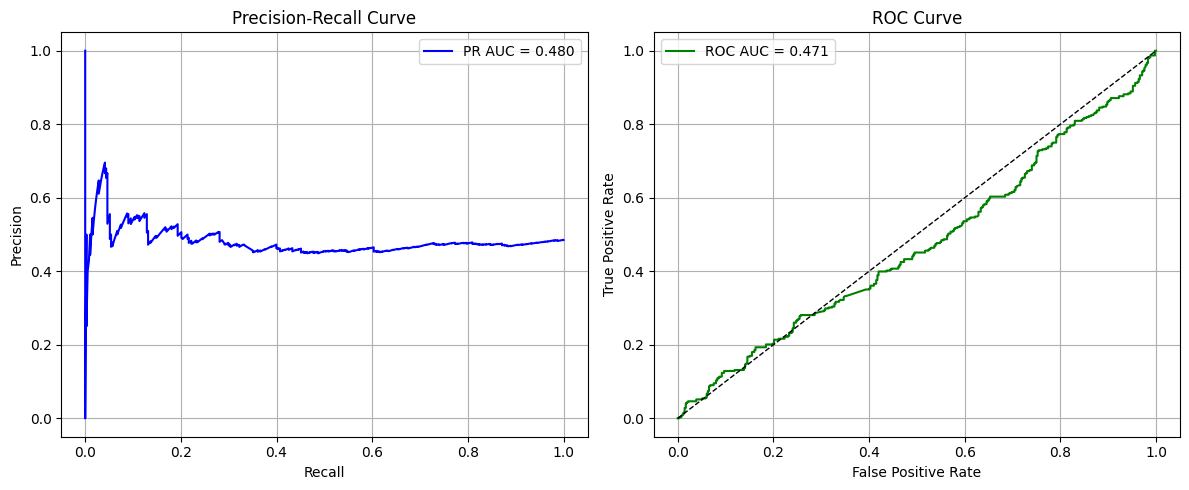

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

proba_train = cb.predict_proba(train.Text)[:, 1]
proba_val   = cb.predict_proba(val.Text)[:, 1]

# PR кривая
precision, recall, thresholds = precision_recall_curve(train.label, proba_train)
pr_auc = auc(recall, precision)

# ROC кривая
fpr, tpr, _ = roc_curve(train.label, proba_train)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# PR
axes[0].plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}', color='blue')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].set_ylim(-0.05, 1.05)
axes[0].legend()
axes[0].grid(True)
# ROC
axes[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()




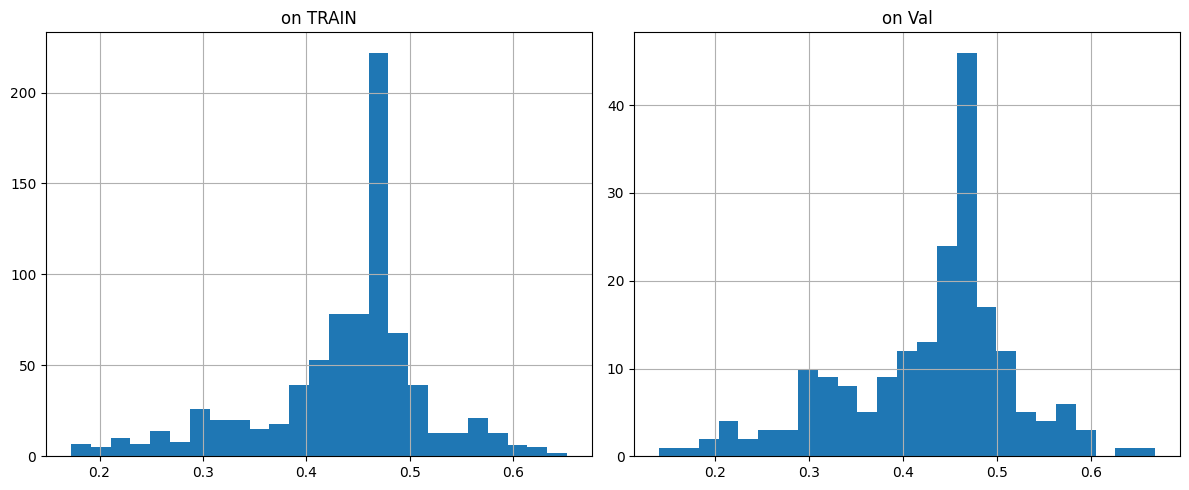

In [ ]:
# посмотрим еще на распределеение вероятностей
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(proba_train, bins=25)
plt.grid()
plt.title(f'on TRAIN')

plt.subplot(1, 2, 2)
plt.hist(proba_val, bins=25)
plt.grid()
plt.title(f'on Val')

plt.tight_layout()
plt.show()

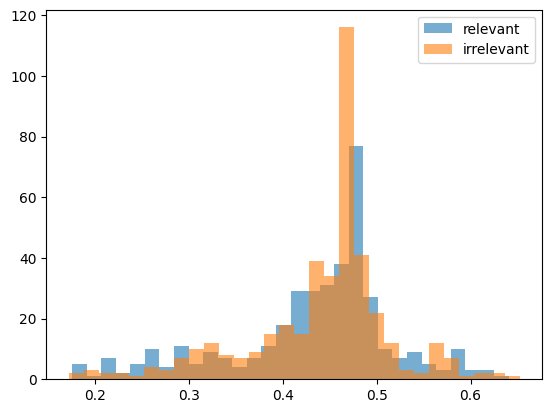

In [ ]:
proba = cb.predict_proba(train.Text)[:, 1]

plt.hist(proba[train.label == 1], bins=30, alpha=0.6, label='relevant')
plt.hist(proba[train.label == 0], bins=30, alpha=0.6, label='irrelevant')
plt.legend()
plt.show()


In [ ]:
f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)
best_idx = np.argmax(f1)

best_threshold = thresholds[best_idx]
best_precision = precision[best_idx]
best_recall = recall[best_idx]
best_f1 = f1[best_idx]

print(f'Best threshold: {best_threshold:.3f}')
print(f'Best precision: {best_precision:.3f}')
print(f'Best recall: {best_recall:.3f}')
print(f'Best F1: {best_f1:.3f}')

Best threshold: 0.176
Best precision: 0.486
Best recall: 1.000
Best F1: 0.654


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_val_marks   = (proba_val > best_threshold).astype(int)
precision_val = precision_score(val.label, y_val_marks)
recall_val    = recall_score(val.label, y_val_marks)
f1_val        = f1_score(val.label, y_val_marks)

print(f'Precision on VAL: {precision_val:.3f}')
print(f'Recall on VAL: {recall_val:.3f}')
print(f'f1 on VAL: {f1_val:.3f}')

Precision on VAL: 0.490
Recall on VAL: 1.000
f1 on VAL: 0.658


Вывод по модели релевантности и подбору порога.

Была обучена бинарная модель классификации на разметке, предоставленной для задания, для определения релевантности веб-документов запросу. Для экспериментов с веб-поиском был создан отдельный датасет из результатов поиска, на котором подбирался порог вероятности для принятия решения «релевантно» / «нерелевантно».

Анализ показал, что предсказанные вероятности моделей сильно перекрываются для двух классов, поэтому интерпретировать их как истинные вероятности некорректно. Вместо этого оптимальный порог был подобран по F1-мере, чтобы обеспечить высокий recall и минимизировать пропуск релевантных документов.

Таким образом, модель используется как фильтрующий классификатор: она отсеивает явно нерелевантные документы и пропускает кандидатов на дальнейшую обработку, что полностью соответствует задаче.